In [12]:
# Description

# Prediction of the target variable exit_stop_id using the variables 
# datetime, route, direction, and stop_id as predictors. Because the 
# target variable is categorical with several categories and sparse, 
# only levels that appeared at least 500 times in the data were included. 
# The variable datetime denotes the date and was converted to a 3-level 
# categorical. The rest of the variables predictor variables were coded
# as integers. 

# The dataset was divided into a training set (80%) and a test set (20%).

# Algorithms: decision tree, k-NN, Random Forest, Bagging, Gradient Boosting, 
# Kernel ridge regression and Neural network.

# The parameters of the models were checked by search to optimize the 
# accuracy in the test set.
# The accuracy of the algorithms ranged from 40% (k-NN) to 63% (Bagging). 
# The neural network gave good results and further tuning can be done 
# to achieve higher accuracy.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import time

# Read CSV file
data = pd.read_csv('result_20210911.csv')
pd.set_option('display.max_rows', None)

# Υπολογισμός αριθμού εγγραφών για κάθε αρχείο
num_rows_file = len(data)
print(f'Αριθμός δεδομένων πριν την επεξεργασία: {num_rows_file}')

unique_stop_id = data['stop_id'].nunique()
unique_exit_stop_ids = data['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id: {unique_stop_id}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id: {unique_exit_stop_ids}')

# Remove rows where "exit_stop_id" or "stop_id" is empty
data = data.dropna(subset=['exit_stop_id', 'stop_id'])

# Drop unnecessary columns

data_cleaned = data.drop(columns=['GarNr', 'ValidTalonaId', 'TripCompanyCode', 'stop_name', "geometry", "exit_geometry", "exit_stop_name"])

# Transform date and time to categorical variable with 3 levels (Early, Mid-day and Late)

bins = ['00:00:00', '03:00:00', '11:00:00', '17:00:00', '23:59:59']
labels = ['Late', 'Early', 'Mid-Day', 'Late']
s = pd.to_timedelta(pd.to_datetime(data_cleaned['datetime']).dt.time.astype(str))
data_cleaned['datetime'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

# Make exit_stop_id the target variable

if 'exit_stop_id' in data_cleaned.columns:
    data_copy = data_cleaned.copy()
    # Assign 'exit_stop_id' as the target variable
    y = data_copy['exit_stop_id']
    data = data_copy.drop(columns=['exit_stop_id'])

Αριθμός δεδομένων πριν την επεξεργασία: 172524
Διακριτές τιμές στη στήλη stop_id: 1516
Διακριτές τιμές στη στήλη exit_stop_id: 1448


In [14]:
# Identify targets with less that 300 ocurrences and remove them from dataset

df = pd.value_counts(y).to_frame().reset_index()
stop_id_counts = data_copy["exit_stop_id"].value_counts()
stop_ids_to_delete = stop_id_counts[stop_id_counts < 500]

# Remove the rows corresponding to the rarest values

df = data_copy[~data_copy['exit_stop_id'].isin(stop_ids_to_delete.index)]

y = df['exit_stop_id']
data = df.drop(columns=['exit_stop_id'])
print("Δεδομενα μετα τον καθαρισμο:", len(data))

unique_stop_id_updated = data['stop_id'].nunique()
unique_exit_stop_ids_updated = df['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: {unique_stop_id_updated}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: {unique_exit_stop_ids_updated}')


# Convert categories to integers for classification
data["datetime"] = pd.factorize(data["datetime"])[0]
data["route"] = pd.factorize(data["route"])[0]
data["direction"] = pd.factorize(data["direction"])[0]
data["stop_id"] = pd.factorize(data["stop_id"])[0]
y = pd.factorize(y)[0]

# Create training and test subsets

x_train, x_test, y_train, y_test=train_test_split(data, y, test_size=0.20,random_state=0)


# Υπολογισμός ποσοστού για καθεμία από τις κατηγορίες στα καθαρισμένα δεδομένα
category_counts_cleaned = df['datetime'].value_counts(normalize=True) * 100

# Εκτύπωση των ποσοστών για καθεμία από τις κατηγορίες
print(f"Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):")
print(f"Late: {category_counts_cleaned.get('Late', 0):.2f}%")
print(f"Early: {category_counts_cleaned.get('Early', 0):.2f}%")
print(f"Mid-Day: {category_counts_cleaned.get('Mid-Day', 0):.2f}%")

Δεδομενα μετα τον καθαρισμο: 9537
Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: 766
Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: 12
Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):
Late: 13.86%
Early: 36.95%
Mid-Day: 49.19%


C:\Users\ilian\AppData\Local\Temp\ipykernel_14824\4257896153.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df = pd.value_counts(y).to_frame().reset_index()


In [15]:
# The algorithms that are used are

## Decision tree
## Random Forest
## Bagging
## Gradient Boosting
## Kernel ridge regression
## Neural network

In [16]:
# Decision tree

tree = DecisionTreeClassifier(random_state=2024)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Tree Test Accuracy:", acc)

# Bagging

bagging = BaggingClassifier(n_estimators=200, random_state=2024)
bagging.fit(x_train, y_train)
y_pred = bagging.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Bagging test accuracy score: {score}")

# Random Forest

rf = RandomForestClassifier(n_estimators=10, max_features = 'sqrt', random_state=2024)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Random Forest test accuracy score: {score}")

# XGBoost
xgboost_model = xgb.XGBClassifier(n_estimators=65, learning_rate=0.1, random_state=2024)
xgboost_model.fit(x_train, y_train) 
y_pred = xgboost_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"XGBoost test accuracy score: {score}")

# LightGBM 
lgbm_model = lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=2024, verbose= -1)
lgbm_model.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test) 
score = accuracy_score(y_test, y_pred) 
print(f"LightGBM test accuracy score: {score}")

Tree Test Accuracy: 0.6907756813417191
Bagging test accuracy score: 0.689203354297694
Random Forest test accuracy score: 0.6808176100628931
XGBoost test accuracy score: 0.6933962264150944
LightGBM test accuracy score: 0.6986373165618449


Decision Tree Results: 
    Depth  Accuracy  Cumulative Time (s)
0       1  0.247379             0.005743
1       2  0.355346             0.012134
2       3  0.421384             0.015784
3       4  0.491614             0.021012
4       5  0.534067             0.028014
5       6  0.556080             0.034015
6       7  0.605870             0.042017
7       8  0.604822             0.050018
8       9  0.632075             0.058020
9      10  0.653040             0.066022
10     11  0.667715             0.074038
11     12  0.674528             0.082081
12     13  0.682914             0.089245
13     14  0.682390             0.096852
14     15  0.687107             0.104910
15     16  0.684486             0.111942
16     17  0.690776             0.119983
17     18  0.690252             0.127998
18     19  0.690776             0.136001
19     20  0.693396             0.144002


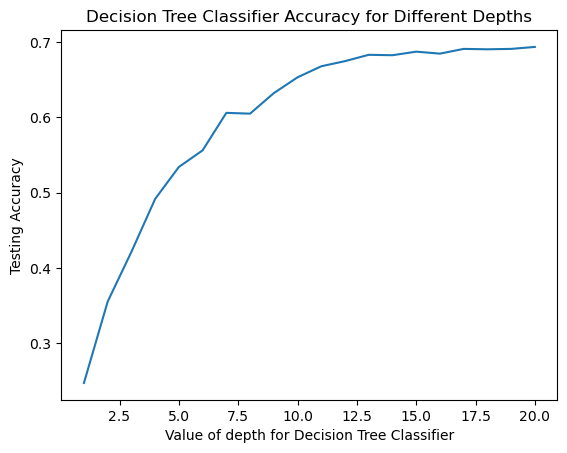

In [17]:
# Decision Tree

import matplotlib.pyplot as plt
%matplotlib inline

scores = []
times = []
total_time = 0
depths = range(1, 21)
for depth in depths:
    start_time = time.time()
    tree = DecisionTreeClassifier(max_depth=depth, random_state=2024)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_dt = pd.DataFrame({'Depth': depths, 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Decision Tree Results: ")
print(df_dt)

plt.plot(depths, scores)
plt.xlabel('Value of depth for Decision Tree Classifier')
plt.ylabel('Testing Accuracy')
plt.title('Decision Tree Classifier Accuracy for Different Depths')
plt.show()

Bagging Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.677673             0.018187
1              2  0.691300             1.238867
2              3  0.694969             2.391545
3              4  0.698113             3.623865
4              5  0.687107             4.958187
5              6  0.691824             6.505278
6              7  0.686059             6.554119
7              8  0.688155             6.616878
8              9  0.691824             8.408342
9             10  0.693396             8.454420
10            11  0.694444             8.532764
11            12  0.699161             8.610528
12            13  0.696017             8.689291
13            14  0.694444             8.765518
14            15  0.694444             9.467829
15            16  0.696541            10.949224
16            17  0.693396            11.026158
17            18  0.693920            11.102731
18            19  0.695493            11.179569
19            20  0.69

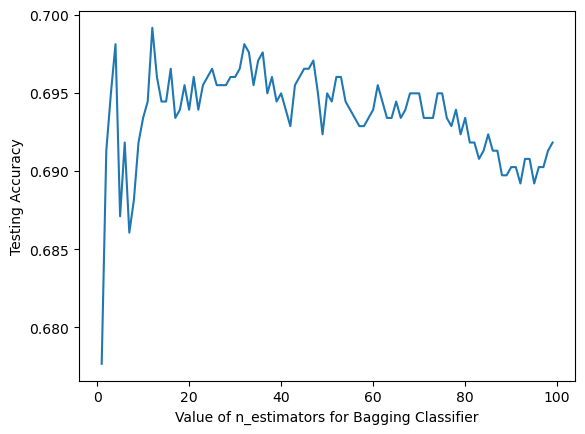

In [18]:
## Bagging for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    bagging = BaggingClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    bagging.fit(x_train, y_train)
    y_pred = bagging.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_bagging = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Bagging Results: ")
print(df_bagging)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Bagging Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

Random Forest Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.658805             0.044180
1              2  0.670335             0.086370
2              3  0.671908             0.133661
3              4  0.681342             0.178777
4              5  0.673480             0.242085
5              6  0.677149             0.288460
6              7  0.675052             0.350394
7              8  0.678721             0.413684
8              9  0.680818             0.475156
9             10  0.680818             0.534901
10            11  0.682914             0.612339
11            12  0.689203             0.689284
12            13  0.687631             0.766228
13            14  0.689727             0.844748
14            15  0.688155             0.924451
15            16  0.690776             1.001051
16            17  0.688155             1.078178
17            18  0.688679             1.158113
18            19  0.691300             1.234136
19            20

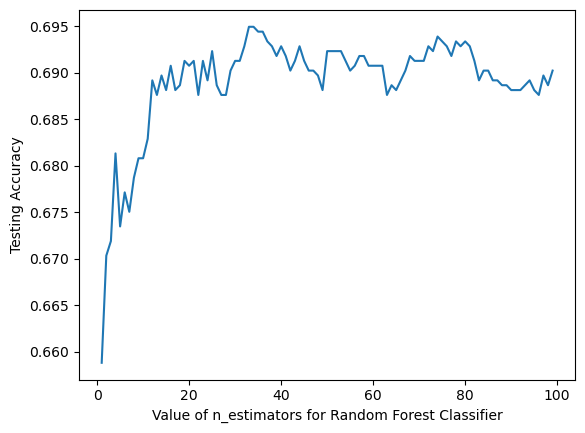

In [19]:
## Random Forest for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    rfc = RandomForestClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_rfc = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Random Forest Results: ")
print(df_rfc)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

XGBoost Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.658805             0.021008
1              2  0.659329             0.039012
2              3  0.669287             0.059016
3              4  0.668239             0.082021
4              5  0.680818             0.107530
5              6  0.684486             0.137537
6              7  0.683438             0.170453
7              8  0.678197             0.208237
8              9  0.680294             0.251247
9             10  0.682390             0.307105
10            11  0.681342             0.361117
11            12  0.684486             0.413070
12            13  0.684486             0.468566
13            14  0.688155             0.536146
14            15  0.688155             0.599367
15            16  0.688155             0.668790
16            17  0.690252             0.742309
17            18  0.690776             0.819953
18            19  0.690776             0.902160
19            20  0.69

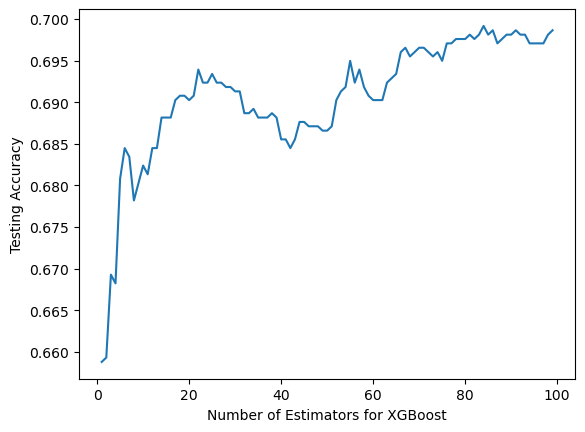

In [20]:
# List to store accuracy scores

xgboost_scores = []
xgboost_times = []
total_time = 0

for n in range(1, 100):
    start_time = time.time()
    xgboost_model = xgb.XGBClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbosity=0)
    xgboost_model.fit(x_train, y_train)
    y_pred = xgboost_model.predict(x_test)
    xgboost_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    xgboost_times.append(total_time)  # Store cumulative time

df_xgboost = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': xgboost_scores, 'Cumulative Time (s)': xgboost_times})
print("XGBoost Results: ")
print(df_xgboost)

plt.plot(range(1, 100), xgboost_scores)
plt.xlabel('Number of Estimators for XGBoost')
plt.ylabel('Testing Accuracy')
plt.show()

LightGBM Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.578092             0.019978
1              2  0.676101             0.037044
2              3  0.684486             0.059140
3              4  0.680818             0.086653
4              5  0.687107             0.115213
5              6  0.682914             0.152772
6              7  0.683962             0.193341
7              8  0.682914             0.239590
8              9  0.684486             0.288915
9             10  0.685010             0.346035
10            11  0.681866             0.402552
11            12  0.685010             0.464131
12            13  0.683962             0.532925
13            14  0.684486             0.611486
14            15  0.682914             0.697855
15            16  0.686583             0.791166
16            17  0.688155             0.890490
17            18  0.689727             0.989932
18            19  0.688155             1.098148
19            20  0.6

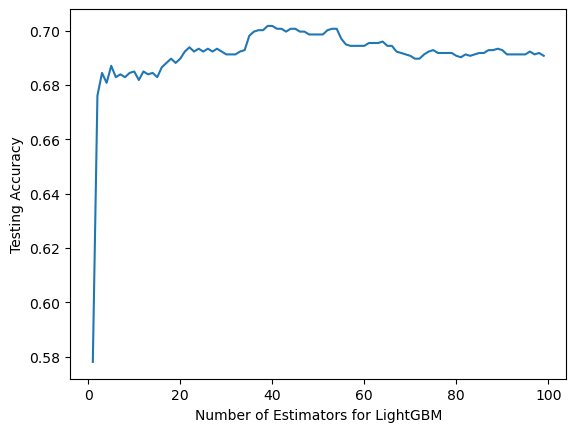

In [21]:
# List to store accuracy scores
lightgbm_times = []
lightgbm_scores = []
total_time = 0

for n in range(1, 100):
    start_time = time.time()
    lgbm_model = lgb.LGBMClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbose=-1)
    lgbm_model.fit(x_train, y_train)
    y_pred = lgbm_model.predict(x_test)
    lightgbm_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    lightgbm_times.append(total_time)  # Store cumulative time

df_lgbm = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': lightgbm_scores, 'Cumulative Time (s)': lightgbm_times})
print("LightGBM Results: ")
print(df_lgbm)

plt.plot(range(1, 100), lightgbm_scores)
plt.xlabel('Number of Estimators for LightGBM')
plt.ylabel('Testing Accuracy')
plt.show()

(6675, 4) (1431, 4) (1431, 4) (6675, 12) (1431, 12) (1431, 12)
Epoch 1/65
223/223 [==============================] - 1s 2ms/step - loss: 2.1492 - accuracy: 0.2736 - val_loss: 1.8996 - val_accuracy: 0.3508
Epoch 2/65
223/223 [==============================] - 0s 1ms/step - loss: 1.8566 - accuracy: 0.3543 - val_loss: 1.8009 - val_accuracy: 0.3641
Epoch 3/65
223/223 [==============================] - 0s 1ms/step - loss: 1.7744 - accuracy: 0.3759 - val_loss: 1.7411 - val_accuracy: 0.3906
Epoch 4/65
223/223 [==============================] - 0s 1ms/step - loss: 1.7195 - accuracy: 0.3834 - val_loss: 1.7005 - val_accuracy: 0.3899
Epoch 5/65
223/223 [==============================] - 0s 1ms/step - loss: 1.6797 - accuracy: 0.3862 - val_loss: 1.6827 - val_accuracy: 0.4025
Epoch 6/65
223/223 [==============================] - 0s 1ms/step - loss: 1.6522 - accuracy: 0.3867 - val_loss: 1.6638 - val_accuracy: 0.3829
Epoch 7/65
223/223 [==============================] - 0s 1ms/step - loss: 1.6308 - ac

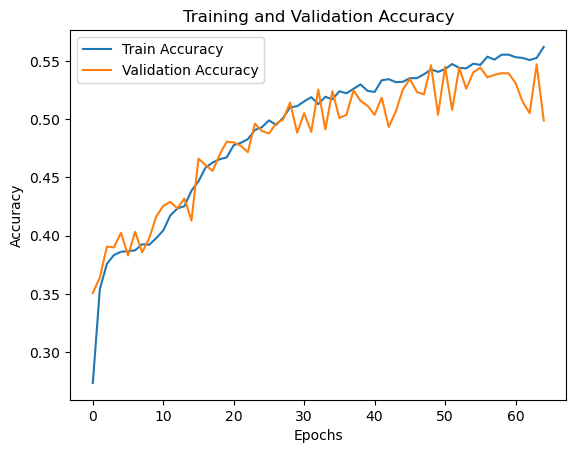

In [22]:
## Neural network 

from keras.models import Sequential
from keras.layers import Dense
from keras import backend

dummy_y = to_categorical(y, num_classes=None)
scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(data, dummy_y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

model = Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_initializer="normal"),
    Dense(64, activation='relu', kernel_initializer="normal"),
    Dense(unique_exit_stop_ids_updated, activation='softmax', kernel_initializer="normal"),  # εξοδος το unique_exit_stop_ids_updated (δηλ οι Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο)
])


# Create the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=30, epochs=65,
          validation_data=(X_val, Y_val))

model.evaluate(X_test, Y_test)[1]

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Plot the accuracy
plot_accuracy(hist)